In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('HPG Historical Data.csv')
df1=df.reset_index()['Price']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.75 * len(df1))
test_size = int(0.15 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 42ms/step - loss: 0.0789 - val_loss: 0.0254
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 3/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 4/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 5/100
14/14 [==============================] - 1s 59ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 6/100
14/14 [==============================] - 1s 50ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/100
14/14 [==============================] - 1s 55ms/step - loss: 0.0012 - val_loss: 3.8152e-04
Epoch 8/100
14/14 [==============================] - 1s 49ms/step - loss: 0.0012 - val_loss: 4.9083e-04
Epoch 9/100
14/14 [==============================] - 1s 53ms/step - loss: 0.0010 - val_loss: 2.7116e-04
Epoch 10/100
14/14 [==============================] - 1s 46ms/step - loss: 9.7671e-04 - 

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 43ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.40200208854620373
Testing RMSE: 0.5618499173329488


In [14]:
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = np.mean(abs(y_pred_val - yval))
test_mae = np.mean(abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.3309940304565429
Testing MAE: 0.48053953126419424


In [15]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs(y_pred_val - yval)/np.abs(y_pred_val))
test_mape = np.mean(np.abs(y_pred - ytest)/np.abs(y_pred))

print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.02775757452673089
Testing MAPE: 0.04427480829158103


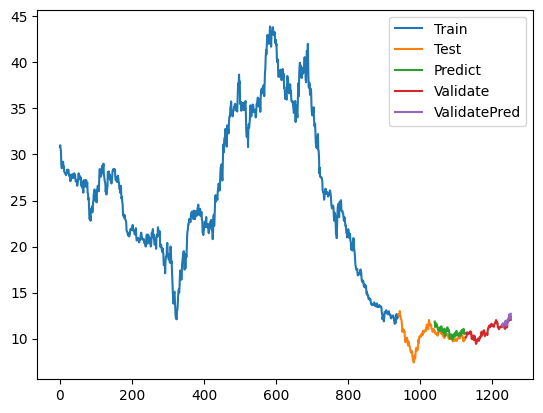

In [16]:
# 14.Vẽ hình
# Train
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
# Test
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
# Dự đoán trên tập test
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
# Validate
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
# Dự đoán trên tập validated
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()